In [1]:
import torch 
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image, make_grid
from torch.autograd import Variable
import matplotlib.pyplot as plt
import matplotlib

from torchsummary import summary

import PIL
from PIL import Image

import glob
import time

from random import randrange

import v2_4 as QuickGAN
from QuickImageDatasets import ImageDataset
from plotAllLosses import plotLosses, checkBound, avg_loss

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython: from IPython import display
if is_ipython: display.clear_output(wait=True)

In [2]:
def shapeSample(_imgs, _recon):
    depth  = _imgs[:,0:1]
    normal = _imgs[:,1:4]
    obj    = _imgs[:,4:5]
    depth  = torch.cat((depth, depth, depth), dim=1)
    obj    = torch.cat((obj, obj, obj), dim=1)
    
    r_depth  = _recon[:,0:1]
    r_normal = _recon[:,1:4]
    r_obj    = _recon[:,4:5]
    r_depth  = torch.cat((r_depth, r_depth, r_depth), dim=1)
    r_obj    = torch.cat((r_obj, r_obj, r_obj), dim=1)

    return [depth, r_depth, normal, r_normal, obj, r_obj]

In [3]:
def save_sample(imgs, recon, epoch):
    imgs = shapeSample(imgs, recon)
    batch_size = 8 if imgs[0].shape[0] > 8 else imgs[0].shape[0]
    grid_imgs = []
    for img_seq in imgs:
        grid_imgs.append(make_grid(img_seq[0:batch_size], nrow=1, normalize=False))
    imgs_all = torch.cat(grid_imgs, dim=-1)
    save_image(imgs_all, sample_path + model_name + ("_%d.png" % epoch))

In [4]:
def autoencoderPath(epoch):
    return saved_model_path + model_name + ("_%d.pth" % epoch)

In [5]:
cuda = torch.cuda.is_available()

autoencoder = QuickGAN.MetaAutoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3, weight_decay=1e-5)

if cuda:
    autoencoder = autoencoder.cuda()
    criterion = criterion.cuda()

Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

In [6]:
saved_model_path = "X:/QuickRender/SavedModels/"
sample_path  = "X:/Datasets/DNO_Samples/"
dataset_root = "X:/Datasets/"
model_name   = "DNO_Autoencoder"
training_set = "SuperRes3_train"
testing_set  = "SuperRes3_test"

In [7]:
resolution = 256
batch_size = 128
start_epoch = 0
epochs = 100
train_data_loader = torch.utils.data.DataLoader(
    dataset=ImageDataset(dataset_root + training_set, (resolution,resolution)), 
    batch_size=batch_size, 
    shuffle=True
)
test_data_loader = torch.utils.data.DataLoader(
    dataset=ImageDataset(dataset_root + testing_set, (resolution,resolution)), 
    batch_size=batch_size, 
    shuffle=True
)

In [8]:
if start_epoch > 0:
    autoencoder.load_state_dict(torch.load(autoencoderPath(start_epoch)))

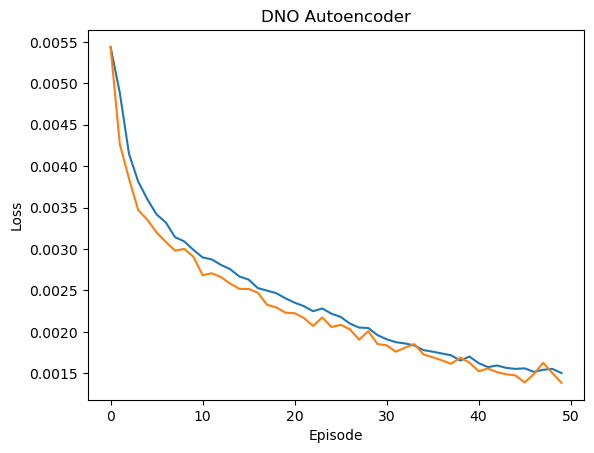

[Epoch 50/100] 
[Train: 0.001502] 
[Test: 0.001383] 
Elapsed Time 6:23:13


In [ ]:
trainLosses = []
testLosses  = []
outputs = []
sample_interval = 100

labels = ["Train", "Test"]

start_time = time.time()

img, recon = None, None

for epoch in range(start_epoch, epochs + 1):
    holdTrainLosses = []
    holdTestLosses  = []
    torch.set_grad_enabled(True)
    for images in train_data_loader:
        img = Variable(images["hr"].type(Tensor))
        img = img[:, 3:8]
        recon = autoencoder(img)
        loss = criterion(recon, img)
        holdTrainLosses.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
    save_sample(img, recon, epoch+1)
    
    torch.set_grad_enabled(False)
    for images in test_data_loader:
        img = Variable(images["hr"].type(Tensor))
        img = img[:, 3:8]
        recon = autoencoder(img)
        loss = criterion(recon, img)
        holdTestLosses.append(loss.item())
        
        
    testLosses.append(avg_loss(holdTestLosses))
    if epoch == 0:
        trainLosses.append(testLosses[-1])
    else:
        trainLosses.append(avg_loss(holdTrainLosses))
    
    plotLosses(
        "DNO Autoencoder",
        epoch+1,
        epochs,
        [trainLosses,testLosses],
        labels,
        start_time
    )
    
    torch.save(autoencoder.state_dict(), autoencoderPath(epoch+1))